<a href="https://colab.research.google.com/github/tirthbha/23-Homework7G1/blob/rectangles_configurations/rectangle_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
# Equilibrium configuration of Rectangle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import itertools
import scipy.optimize

ke2 = 1.44 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0317    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)
        self.potentials_per_step = []

    def callback(self, xk):
        """
        Callback function to capture the potential at each step.
        """
        self.set_vals(xk)
        self.potentials_per_step.append(self.V())

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_

    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        potential = self.V()
        return potential

In [153]:
# Define side lengths 'a' and 'b'
a = 0.2 # length
b = 0.3 # width
h = a # height

# Define rectangle configuration for Na+ and Cl- ions
r_na = np.array([[0, 0, 0], [a, 0, a], [0, b, a], [a, b, 0]])
r_cl = np.array([[0, 0, a], [a, 0, 0], [0, b, 0], [a, b, a]])

# Create Cluster instance
cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

# Optimization using scipy.optimize.minimize
res = scipy.optimize.minimize(fun=cluster, x0=vals_init, tol=1e-3, method="BFGS", callback=cluster.callback)
cluster.set_vals(res.x)  # Update cluster with optimized positions
print("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)
print("Number of iterations:", res.nit)

initial Na positions:
 [[0.  0.  0. ]
 [0.2 0.  0.2]
 [0.  0.3 0.2]
 [0.2 0.3 0. ]]
initial Cl positions:
 [[0.  0.  0.2]
 [0.2 0.  0. ]
 [0.  0.3 0. ]
 [0.2 0.3 0.2]]
initial positions flattened shape:
 [0.  0.  0.  0.2 0.  0.2 0.  0.3 0.2 0.2 0.3 0.  0.  0.  0.2 0.2 0.  0.
 0.  0.3 0.  0.2 0.3 0.2]
initial V  : -22.239686552618835
Final optimized cluster positions
[[-0.03438821  0.01054768 -0.00837824]
 [ 0.21697267  0.03736119  0.25115846]
 [-0.02123079  0.30574064  0.20125709]
 [ 0.23852669  0.24612531 -0.04416039]
 [-0.03858767  0.05376572  0.24409741]
 [ 0.22117322 -0.00585087 -0.00131815]
 [-0.01703275  0.26252847 -0.05121914]
 [ 0.2343262   0.28933966  0.20831784]]
Final potential: -28.689140765859342
Number of iterations: 32


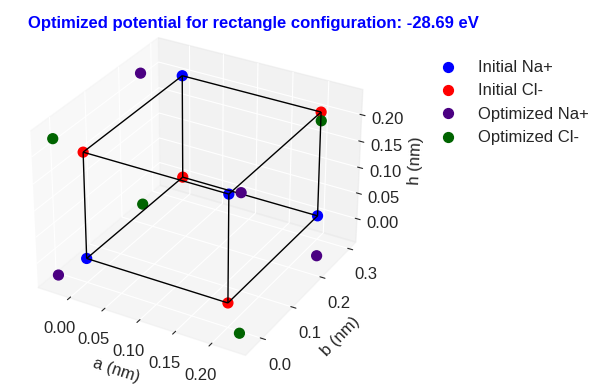

In [154]:
# Plotting
# Combine Na+ and Cl- positions
positions = np.vstack((r_na, r_cl))

# Define connections between ions for line plotting
lines = [
    [0, 5],
    [0, 4],
    [0, 6],
    [4, 1],
    [4, 2],
    [1, 7],
    [7, 2],
    [7, 3],
    [6, 2],
    [5, 3],
    [6, 3],
    [1, 5]
]

# Prepare the points for line plotting
# Each line segment is defined by a pair of points.
points = np.array([positions[idx] for idx_pair in lines for idx in idx_pair])
      # The 'points' array is reshaped to form a series of line segments.
      # Each segment is represented by two points (start and end),
      # and each point has three coordinates (x, y, z). The resulting shape is (-1, 2, 3),
      # where -1 allows numpy to automatically
      # determine the necessary size based on the length of 'lines'.
lines = points.reshape(-1, 2, 3)


# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', facecolor='white', alpha=1 )
#plt.figure(figsize=(8, 10))
# Plot initial positions for Na+ and Cl-
ax.scatter(r_na[:,0], r_na[:,1], r_na[:,2], c='blue', label='Initial Na+', s=50, alpha=1)
ax.scatter(r_cl[:,0], r_cl[:,1], r_cl[:,2], c='red', label='Initial Cl-', s=50, alpha=1)

# Plot optimized positions for Na+ and Cl-
ax.scatter(optimized_r_na[:,0], optimized_r_na[:,1], optimized_r_na[:,2], c='indigo', label='Optimized Na+', s=50, alpha=1)
ax.scatter(optimized_r_cl[:,0], optimized_r_cl[:,1], optimized_r_cl[:,2], c='darkgreen', label='Optimized Cl-', s=50, alpha=1)

# Add the lines for initial positions
line_collection = Line3DCollection(lines, colors='black', linewidths=1, alpha=1)
ax.add_collection3d(line_collection)

# Set labels and legend
ax.set_xlabel('a (nm)')
ax.set_ylabel('b (nm)')
ax.set_zlabel('h (nm)')
ax.text2D(0.05, 0.95, "Optimized potential for rectangle configuration: -28.69 eV", transform=ax.transAxes, color='blue', weight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.75))
plt.show()

<Figure size 640x480 with 0 Axes>

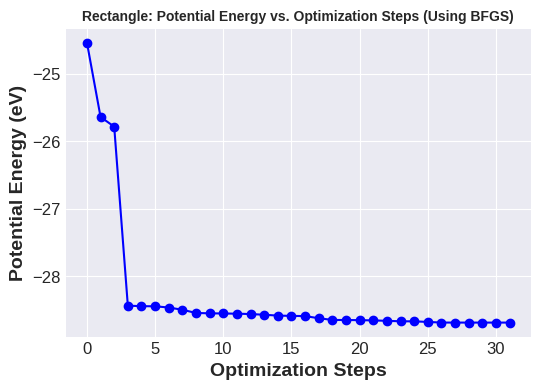

In [155]:
# Plotting the potential energy vs. optimization steps
plt.figure()
plt.rcParams['font.size'] = 12
# Plotting the potential energy vs. optimization steps
plt.figure(figsize=(6, 4))
plt.plot(cluster.potentials_per_step, marker='o', linestyle='-', color='blue', linewidth=1.5, markersize=6)
plt.xlabel('Optimization Steps', fontsize=14, fontweight='bold')
plt.ylabel('Potential Energy (eV)', fontsize=14, fontweight='bold')
plt.title('Rectangle: Potential Energy vs. Optimization Steps (Using BFGS)', fontsize=10, fontweight='bold')
plt.show()
